In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit
from scipy import optimize
import corner
from IPython.display import display, Math
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import statsmodels.api as sm

In [2]:
data = np.load('transient.npy')
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

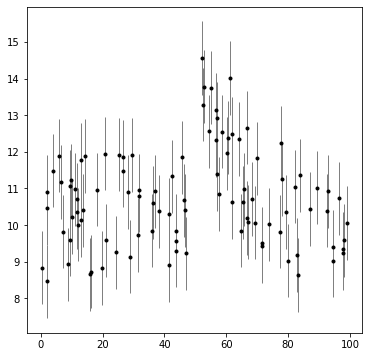

In [3]:
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

In [4]:
# coding the model
def model(t, theta):
    A, b, t_0, alpha = theta
    
    arg = -alpha * (t - t_0)

    exp_term = np.exp(np.clip(arg, a_min=-700, a_max=700))
    
    return np.where(t < t_0, b, b + A * exp_term)
    
def model_fit(t, A, b, t_0, alpha):
    
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

C:\Users\loren\AppData\Local\Temp\ipykernel_21572\3177836826.py:13: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))


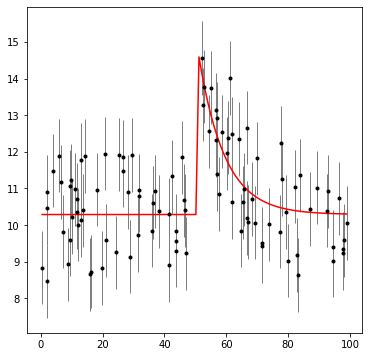

In [5]:
popt, pcov = curve_fit(model_fit, time, flux, p0=[5,10,50,0.1])
A_opt, b_opt, t0_opt, alpha_opt = popt
x_model = np.linspace(min(time), max(time), 100)
y_model = model_fit(x_model, A_opt, b_opt, t0_opt, alpha_opt)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

plt.plot(x_model, y_model, color='r')
plt.show()

In [6]:
A = popt[0]
b = popt[1]
t_0 = popt[2]
alpha = popt[3]

In [8]:
def loglike(theta):
    
    A, b, t_0, alpha = theta
    model_flux = model(time, theta)
    
    return -0.5 * np.sum(((flux - model_flux) / flux_err) ** 2)

def ptform(u):
    
    x = np.array(u)
    
    lower_bound = [0, 0, 0, np.exp(-5)]
    upper_bound = [50, 50, 100, np.exp(5)]
    
    x = [lower_bound[i] + u[i] * (upper_bound[i] - lower_bound[i]) for i in range(len(u))]
    
    return x

In [10]:
ndim = 4
#sampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim, sample='rwalk')
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=300, sample='rwalk')
sampler.run_nested()
sresults = sampler.results

6000it [00:33, 179.31it/s, +300 | bound: 112 | nc: 1 | ncall: 128767 | eff(%):  4.904 | loglstar:   -inf < -48.758 <    inf | logz: -67.476 +/-  0.244 | dlogz:  0.001 >  0.309]


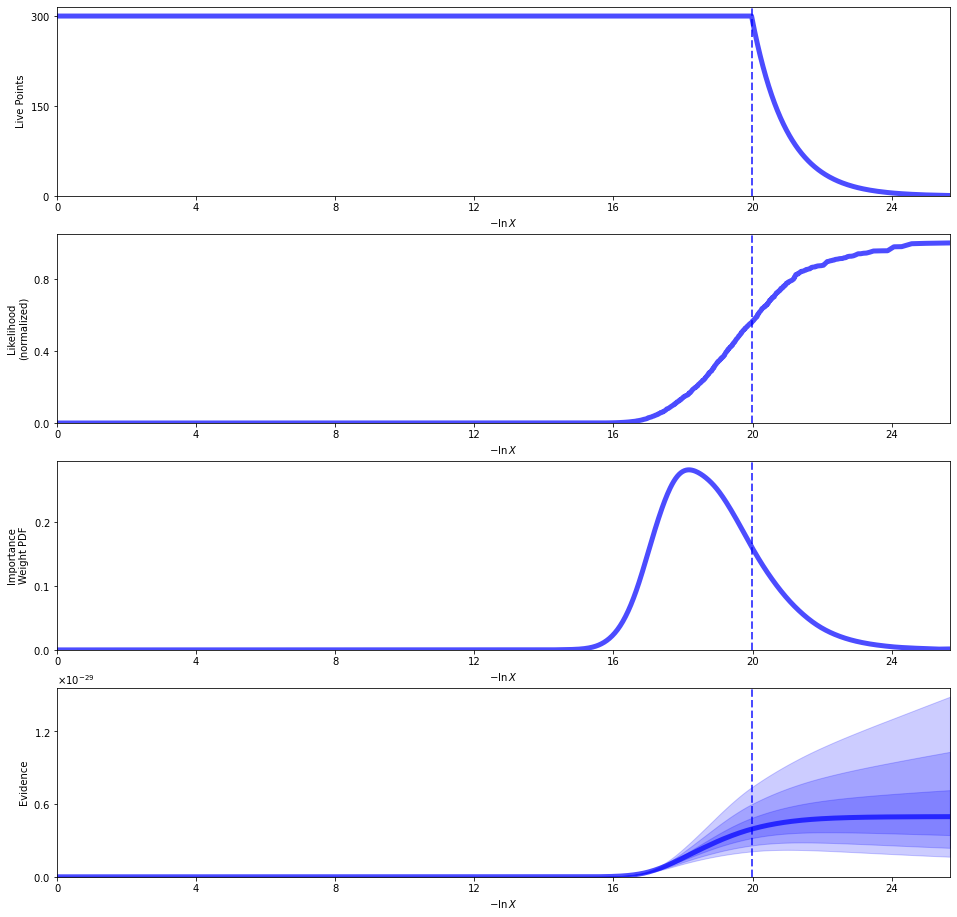

In [11]:
rfig, raxes = dyplot.runplot(sresults)

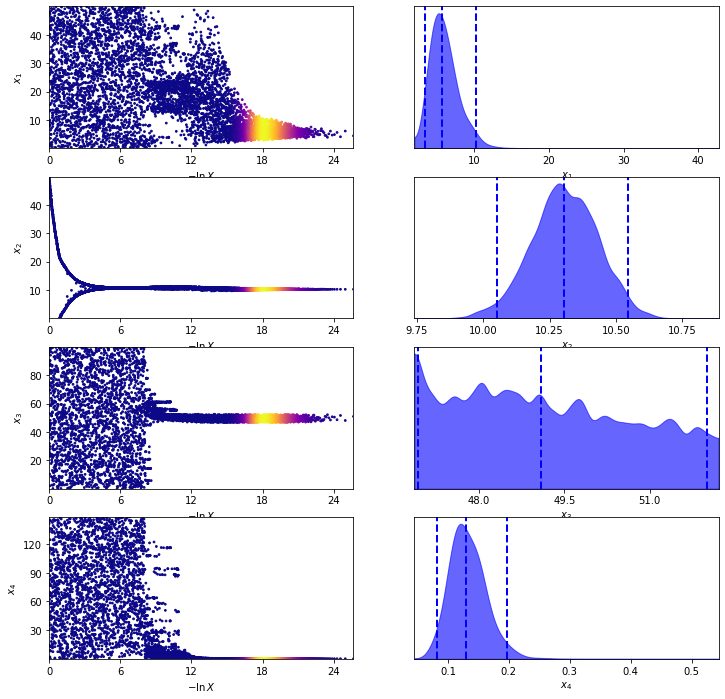

In [12]:
tfig, taxes = dyplot.traceplot(sresults)

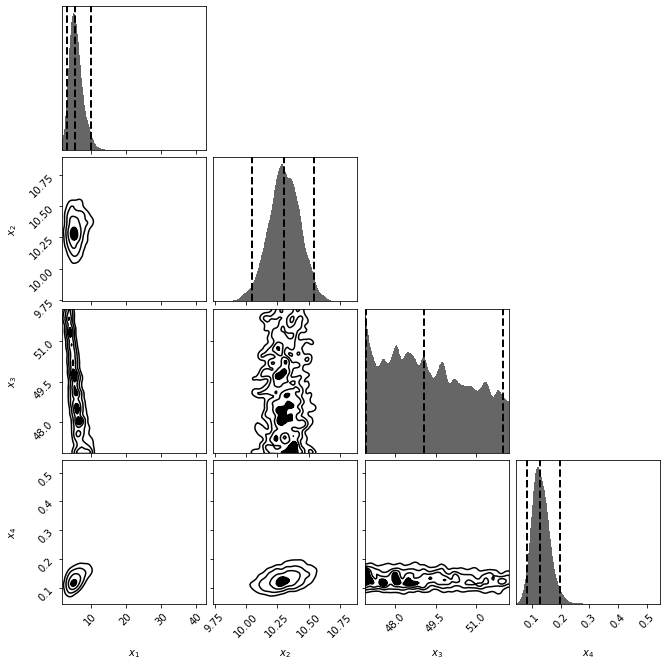

In [13]:
cfig, caxes = dyplot.cornerplot(sresults)

In [14]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_burst = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_burst))

# Compute 5%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.05, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 4.963062196902675e-30
90% parameter credible regions are:
 [[3.6286222644194326, 8.457154508714828], [10.099431420503263, 10.461441533532422], [47.02577674805613, 51.46101208164264], [0.08995647185585934, 0.1694660572599775]]

Mean and covariance of parameters are: [ 5.95471796 10.30572364 49.24352027  0.13246108]
[[ 3.40239304e+00  2.39476430e-02 -1.92634455e+00  3.29162628e-02]
 [ 2.39476430e-02  1.55246261e-02 -6.34665986e-03  1.51916568e-03]
 [-1.92634455e+00 -6.34665986e-03  2.29035712e+00 -4.11997428e-03]
 [ 3.29162628e-02  1.51916568e-03 -4.11997428e-03  8.73589402e-04]]


In [15]:
samples_equal = dyfunc.resample_equal(samples, weights)

In [16]:
quantile_values_68 = np.percentile(samples_equal, 68, axis=0)
quantile_values_95 = np.percentile(samples_equal, 95, axis=0)

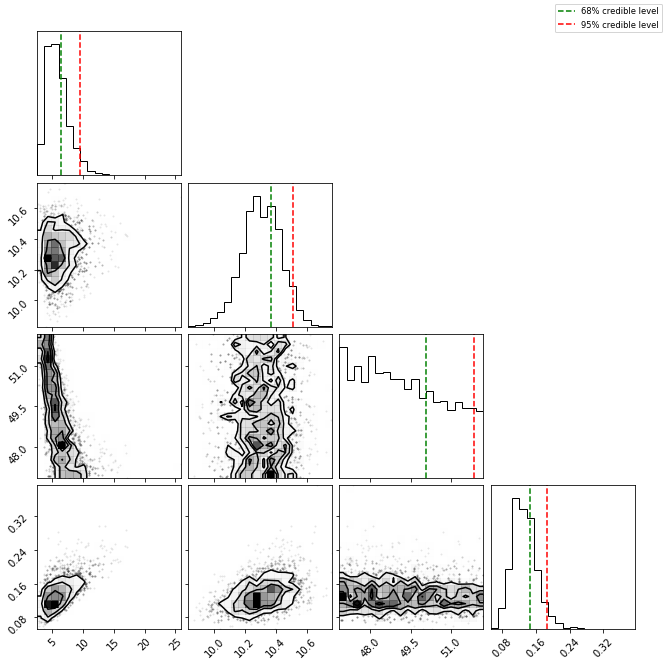

In [17]:
fig = corner.corner(samples_equal)

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(quantile_values_68[i], color="g", linestyle='dashed')
    ax.axvline(quantile_values_95[i], color="r", linestyle='dashed')

# labels
handles = [
    plt.Line2D([], [], color='g', linestyle='--'),
    plt.Line2D([], [], color='r', linestyle='--')
]

labels = ['68% credible level', '95% credible level']

plt.figlegend(handles, labels, loc='upper right', fontsize='small');

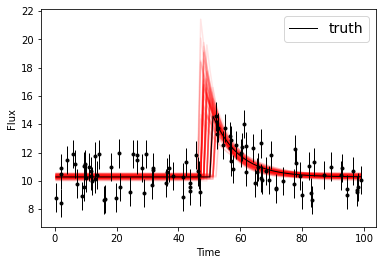

In [18]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_model, model_fit(x_model, sample[0], sample[1], sample[2], sample[3]), "r", alpha=0.1)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", lw=1)
plt.plot(x_model, model_fit(x_model, A, b, t_0, alpha), "k", lw=1, label="truth")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("Flux");

In [19]:
labels = ['A', 'b', 't_0', 'alpha']
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Gaussian profile

In [20]:
def model_gauss(t, theta):
    
    A, b, t_0, sigma = theta
    return b + A*np.exp(-(time-t_0)**2 / (2*sigma**2))

def model_gauss_fit(time, A, b, t_0, sigma):
    
    return b + A*np.exp(-(time-t_0)**2 / (2*sigma**2))

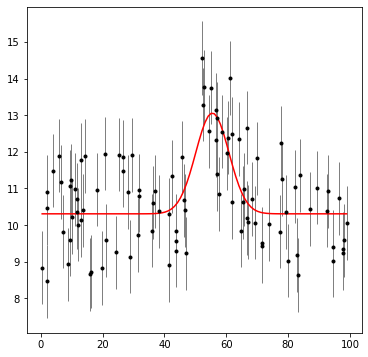

In [21]:
popt, pcov = curve_fit(model_gauss_fit, time, flux, p0=[3,10,55,5])
A_opt, b_opt, t0_opt, sigma_opt = popt
x_model = np.linspace(min(time), max(time), 100)
y_model = model_gauss_fit(x_model, A_opt, b_opt, t0_opt, sigma_opt) 

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

plt.plot(x_model, y_model, color='r')
plt.show()

In [22]:
A_gauss = popt[0]
b_gauss = popt[1]
t_0_gauss = popt[2]
sigma_gauss = popt[3]
print(popt)

[ 2.75113442 10.30693377 55.47300903  5.36943502]


In [23]:
def loglike_gauss(theta):
    
    A, b, t_0, sigma = theta
    model_wgauss = model_gauss(time, theta)
    
    return -0.5 * np.sum(((flux - model_wgauss) / flux_err) ** 2)

def ptform_gauss(u):
    
    # TRY WITH PPF
    
    x = np.array(u)
    
    lower_bound = [0, 0, 0, 0]
    upper_bound = [50, 50, 100, 10]
    
    x = [lower_bound[i] + u[i] * (upper_bound[i] - lower_bound[i]) for i in range(len(u))]
    
    return x

In [24]:
ndim = 4
#sampler = dynesty.DynamicNestedSampler(loglike_gauss, ptform_gauss, ndim, sample='rwalk')
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=300, sample='rwalk')
sampler.run_nested()
sresults = sampler.results

7024it [00:40, 174.16it/s, +300 | bound: 141 | nc: 1 | ncall: 154783 | eff(%):  4.741 | loglstar:   -inf < -48.765 <    inf | logz: -70.893 +/-  0.266 | dlogz:  0.001 >  0.309]


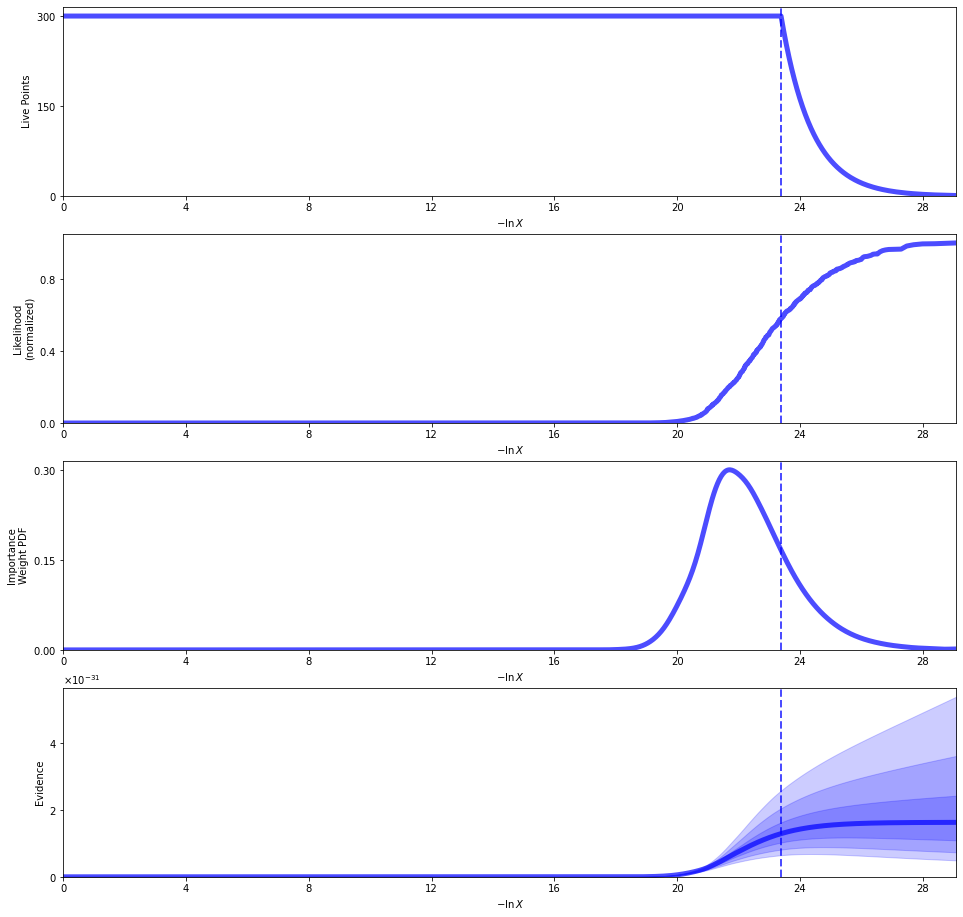

In [25]:
rfig, raxes = dyplot.runplot(sresults)

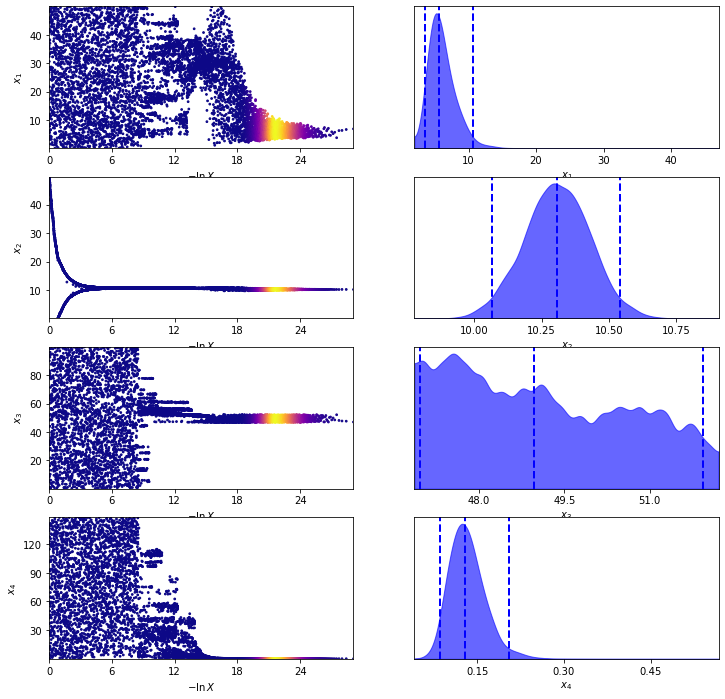

In [26]:
tfig, taxes = dyplot.traceplot(sresults)

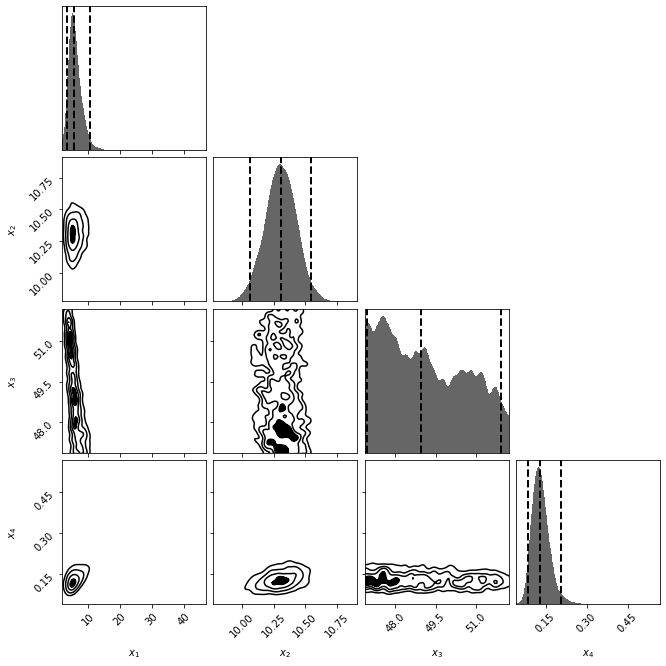

In [27]:
cfig, caxes = dyplot.cornerplot(sresults)

In [28]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_gauss = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gauss))

# Compute 5%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.05, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 1.6274540461246052e-31
90% parameter credible regions are:
 [[3.819196776671133, 8.61544164250668], [10.10170750740629, 10.459800841514381], [47.04471949143764, 51.33631104001773], [0.09046529867314472, 0.17264023614049812]]

Mean and covariance of parameters are: [ 6.06055913 10.30660245 49.14525872  0.13271762]
[[ 3.71718351e+00  3.10091917e-02 -1.90790413e+00  3.71988592e-02]
 [ 3.10091917e-02  1.48498603e-02 -1.27978636e-02  1.51762571e-03]
 [-1.90790413e+00 -1.27978636e-02  2.28213008e+00 -3.29228991e-03]
 [ 3.71988592e-02  1.51762571e-03 -3.29228991e-03  9.45538733e-04]]


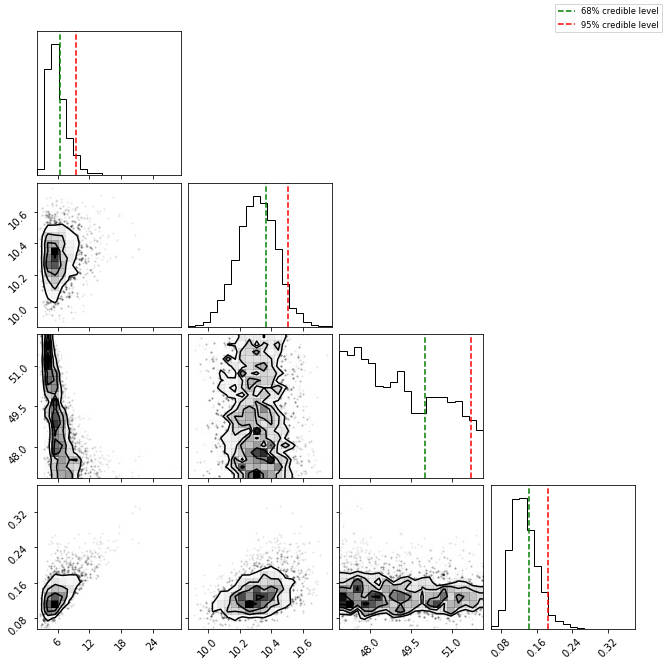

In [29]:
samples_equal = dyfunc.resample_equal(samples, weights)

quantile_values_68 = np.percentile(samples_equal, 68, axis=0)
quantile_values_95 = np.percentile(samples_equal, 95, axis=0)

fig = corner.corner(samples_equal)

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(quantile_values_68[i], color="g", linestyle='dashed')
    ax.axvline(quantile_values_95[i], color="r", linestyle='dashed')

# labels
handles = [
    plt.Line2D([], [], color='g', linestyle='--'),
    plt.Line2D([], [], color='r', linestyle='--')
]

labels = ['68% credible level', '95% credible level']

plt.figlegend(handles, labels, loc='upper right', fontsize='small');

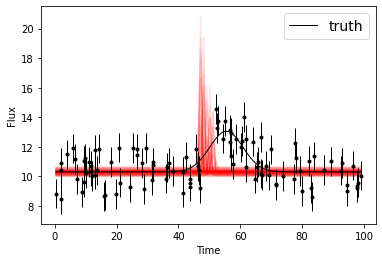

In [30]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(x_model, model_gauss_fit(x_model, sample[0], sample[1], sample[2], sample[3]), "r", alpha=0.1)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", lw=1)
plt.plot(x_model, model_gauss_fit(x_model, A_gauss, b_gauss, t_0_gauss, sigma_gauss), "k", lw=1, label="truth")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("Flux");

I can compute the Bayes factor as  
<center>$Bayes factor = \frac{Z_1}{Z_2}$,</center>  
where $Z_1$ and $Z_2$ are respectively the Bayesian evidence with the burst model and with the gaussian model.

In [31]:
bayes_factor = evidence_burst / evidence_gauss
print('The bayes factor results to be: ', "{:.10f}".format(bayes_factor))

The bayes factor results to be:  0.9517923444
